# Create Explore Results

# Library Import and Functions

In [ ]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
from scipy import stats


## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [4]:
'''
function name: parse_df_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True, is_transcript=False, is_prot=False):

    if is_ref:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)
        
        ## Get gene names
        df["gene_name"] = df["other"].str.split("gene_name \"", expand=True)[1].str.split('\";', expand=True)[0]
        
        ## Get get transcript biotype
        df["gene_biotype"] = df["other"].str.split('gene_biotype "', expand=True)[1].str.split('"', expand=True)[0]
        
        ## If is transcript get transcript id and transcript biotype
        if is_transcript:
            df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]
            df["transcript_biotype"] = df["other"].str.split('transcript_biotype "', expand=True)[1].str.split('"', expand=True)[0]
            df["transcript_name"] = df["other"].str.split('transcript_name "', expand=True)[1].str.split('"', expand=True)[0]
            
            ## If is prot get protein_id
            if is_prot:
                df["protein_id"] = df["other"].str.split('protein_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["ccds_id"] = df["other"].str.split('ccds_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)
        

    else:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)

        ## Get transcript ids
        df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]

        ## Get exon number
        df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)

    for col in df.columns:
        df.loc[df[col].isnull(), col] = np.NaN
        

    return df

# Import data and process AD vs CT data

In [5]:
## Import results for transcript level analysis
res = pd.read_csv("../../data/processed/deseq2/multiple_transcripts_results_AD_vs_CT.tsv", sep="\t")
res.reset_index(inplace=True, drop=False, names="transcript_id")

## Import results for med-relevant transcript level analysis
res_med = pd.read_csv("../../data/processed/deseq2/multiple_transcripts_results_med_relevant_AD_vs_CT.tsv", sep="\t")
res_med.reset_index(inplace=True, drop=False, names="transcript_id")

## Import results for gene level analysis
res_gene = pd.read_csv("../../data/processed/deseq2/genes_AD_vs_CT_results.tsv", sep="\t")
res_gene.reset_index(inplace=True, drop=False, names="gene_id")

In [6]:
## Open original GTF reference
original_ref = pd.read_csv("../../references/Homo_sapiens.GRCh38.107_ERCC.gtf", header=None, delimiter="\t", low_memory=False, 
                       names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"], comment="#")


## Parse through reference to get gene names and ids
orig_ref = original_ref.loc[original_ref["type"]=="transcript"].copy()
orig_ref = parse_df_columns(orig_ref, is_ref=True, is_transcript=True)

In [8]:
## Import and parse through extended annotations generated with Bambu
bambu_ref = pd.read_csv("../../data/raw/nextflow_pipeline_output/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])

bambu_ref = bambu_ref.loc[~bambu_ref["chr"].str.startswith("ERCC-")]

bambu_ref = parse_df_columns(bambu_ref, is_ref=False)

bambu_ref = bambu_ref.loc[bambu_ref["type"] == "transcript"].copy()

bambu_ref = bambu_ref.merge(orig_ref[["transcript_id", "transcript_name"]], on="transcript_id", how="left")

In [9]:
## If transcript does not have transcript_name columns, fill with transcript_id
bambu_ref.loc[bambu_ref["transcript_name"].isna(), "transcript_name"] = bambu_ref["transcript_id"]

In [10]:
## Only keep relevant rows and columns in references
bambu_ref_names = bambu_ref[["gene_id", "transcript_id", "transcript_name"]].copy()

orig_ref_names = orig_ref[["gene_id", "gene_name"]].drop_duplicates().copy()

## If gene_name is empty, fill with gene_id
orig_ref_names.loc[orig_ref_names["gene_name"].isna(), "gene_name"] = orig_ref_names["gene_id"]

In [11]:
# Add annotations to transcript level analysis
res = res.merge(bambu_ref_names, on="transcript_id", how="left")
res = res.merge(orig_ref_names, on=["gene_id"], how="left")

# Add annotations to med-relevant transcript level analysis
res_med = res_med.merge(bambu_ref_names, on="transcript_id", how="left")
res_med = res_med.merge(orig_ref_names, on=["gene_id"], how="left")

# Add annotations to gene level analysis
res_gene = res_gene.merge(orig_ref_names, on=["gene_id"], how="left")

In [12]:
## Save annotated results for transcript level 
res.to_csv("../../data/processed/deseq2/annotated_multiple_transcripts_results_AD_vs_CT.tsv", 
          index=False, sep="\t")


## Save annotated med-relevant results for transcript level
res_med.to_csv("../../data/processed/deseq2/annotated_med_relevant_multiple_transcripts_results_AD_vs_CT.tsv", 
              index=False, sep="\t")

## Save annotated gene level results
res_gene.to_csv("../../data/processed/deseq2/genes_annotated_results_AD_vs_CT.tsv", index=False, sep="\t")

In [13]:
## Filter transcript level results
res_filtered = res.loc[~res["padj"].isna()].copy()
res_filtered = res_filtered.loc[((res_filtered["padj"] < 0.05) & (abs(res_filtered["log2FoldChange"]) > 1))].copy()

## Filter med-relevant transcript level results
res_med_filtered = res_med.loc[~res_med["padj"].isna()].copy()
res_med_filtered = res_med_filtered.loc[((res_med_filtered["padj"] < 0.05) & (abs(res_med_filtered["log2FoldChange"]) > 1))].copy()

## Filter med-relevant gene level results
res_gene_filtered = res_gene.loc[~res_gene["padj"].isna()].copy()
res_gene_filtered = res_gene_filtered.loc[((res_gene_filtered["padj"] < 0.05) & (abs(res_gene_filtered["log2FoldChange"]) > 1))].copy()

In [14]:
## Save filtered results for transcript level 
res_filtered.to_csv("../../data/processed/deseq2/filtered_multiple_transcripts_results_AD_vs_CT.csv", index=False)


## Save filtered med-relevant results for transcript level
res_med_filtered.to_csv("../../data/processed/deseq2/filtered_med_relevant_multiple_transcripts_results_AD_vs_CT.csv", index=False)


## Save filtered gene level results
res_gene_filtered.to_csv("../../data/processed/deseq2/genes_filtered_results_AD_vs_CT.csv")

## Comparison between gene DE with and without intron data - No covariates

In [15]:
## Import results for gene level analysis

res_gene_AD = pd.read_csv("../../data/processed/deseq2/genes_AD_vs_CT_results.tsv", sep="\t")
res_gene_AD.reset_index(inplace=True, drop=False, names="gene_id")

res_gene_no_intron_AD = pd.read_csv("../../data/processed/deseq2/genes_AD_vs_CT_results_no_intron.tsv", sep="\t")
res_gene_no_intron_AD.reset_index(inplace=True, drop=False, names="gene_id")


In [16]:
# Add annotations to AD gene level analysis
res_gene_AD = res_gene_AD.merge(orig_ref_names, on=["gene_id"], how="left")

# Add annotations to AD gene level analysis without intron
res_gene_no_intron_AD = res_gene_no_intron_AD.merge(orig_ref_names, on=["gene_id"], how="left")


In [17]:
## If gene_name is missing, fill with gene_id
res_gene_AD['gene_name'].fillna(value=res_gene_AD["gene_id"], inplace=True)

res_gene_no_intron_AD['gene_name'].fillna(value=res_gene_no_intron_AD["gene_id"], inplace=True)


In [18]:
## Save annotated AD without intron gene  results
res_gene_no_intron_AD.to_csv("../../data/processed/deseq2/genes_annotated_results_AD_vs_CT_no_intron.tsv", index=False, sep="\t")

In [19]:
## Filter results

res_gene_AD_filtered = res_gene_AD.loc[~res_gene_AD["padj"].isna()].copy()
res_gene_AD_filtered = res_gene_AD_filtered.loc[((res_gene_AD_filtered["padj"] < 0.05) & (abs(res_gene_AD_filtered["log2FoldChange"]) > 1))].copy()

res_gene_AD_filtered_no_intron = res_gene_no_intron_AD.loc[~res_gene_no_intron_AD["padj"].isna()].copy()
res_gene_AD_filtered_no_intron = res_gene_AD_filtered_no_intron.loc[((res_gene_AD_filtered_no_intron["padj"] < 0.05) & (abs(res_gene_AD_filtered_no_intron["log2FoldChange"]) > 1))].copy()

In [21]:
## define ggplot colors
ggplot2_colors = ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"]

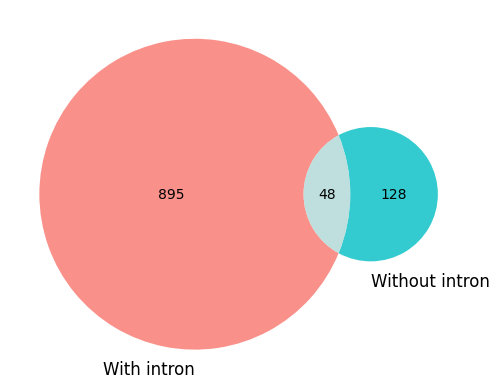

In [24]:
## Create venn diagram for AD gene level results

set_AD = set(res_gene_AD_filtered["gene_id"].to_list())
set_AD_no_intron = set(res_gene_AD_filtered_no_intron["gene_id"].to_list())

venn2([set_AD, set_AD_no_intron], ('With intron', 'Without intron'), 
     set_colors=[ggplot2_colors[0], ggplot2_colors[4]], alpha=0.8)

plt.savefig('../../figures/paper_figures/figure_6/gene_level_AD_vs_CT_venn_diagram_INTRON.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

In [25]:
## Save filtered gene level results without introns for AD
res_gene_AD_filtered_no_intron.to_csv("../../data/processed/deseq2/genes_filtered_results_AD_vs_CT_no_intron.csv")

## Save filtered gene level results without introns for SEX
res_gene_AD_filtered_no_intron.to_csv("../../data/processed/deseq2/genes_filtered_results_M_vs_F_no_intron.csv")